In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn import datasets, linear_model
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from scipy import stats
from sklearn.impute import SimpleImputer
import numpy as np
from sklearn.metrics import accuracy_score
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn import datasets, linear_model
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from scipy import stats
from sklearn.model_selection import cross_val_score
import math
pd.set_option('display.max_columns', None)
pd.set_option('mode.chained_assignment', None)

In [ ]:
df = pd.read_csv('roi_clean.csv')

In [ ]:
# Dropping columns that are not needed
df = df[df['tot_coll_amt'].isna() == False]
to_drop = ['Unnamed: 0', 'recoveries','collection_recovery_fee','last_pymnt_amnt',
           'acc_open_past_24mths', 'all_util', 'num_actv_rev_tl', 'num_rev_tl_bal_gt_0', 
          'open_acc_6m', 'open_act_il', 'open_act_il', 'open_rv_24m', 'pct_tl_nvr_dlq', 
          'total_cu_tl', 'debt_settlement_flag', 'num_tl_120dpd_2m', 'num_tl_30dpd', 
           'hardship_flag', 'disbursement_method', 'pymnt_plan', 'earliest_cr_line', 'sub_grade', 
          'last_pymnt_d', 'mths_since_recent_inq']
df = df.drop(columns=to_drop)

# Mapping categorical employee length variable to numerical values
df['emp_length'] = df['emp_length'].fillna('nan')
df['emp_length'] = df['emp_length'].replace({'10+ years': 10,
                          '3 years': 3,
                          '4 years': 4,
                          '6 years': 6, 
                          '7 years': 7, 
                          '8 years': 8,
                          '2 years': 2, 
                          '5 years': 5, 
                          '9 years': 9, 
                          '< 1 year':0, 
                          '1 year':1, 
                          'nan': 0})

# Mapping categorical grade variable to numerical values
df['grade'] = df['grade'].replace({'A':1,
                                   'B':2,
                                   'C':3,
                                   'D':4,
                                   'E':5,
                                   'F':6,
                                   'G':7})

#Mapping categorical verification status to numerical values
df['verification_status'] = df['verification_status'].replace({'Source Verified':1,
                                                              'Verified':1,
                                                              'Not Verified':0})
#Mapping categorical employee length to numerical values
df['loan_status'] = df['loan_status'].replace(['Fully Paid','Charged Off'],[1,0])

half = len(df)/2
df = df.dropna(thresh=half,axis=1)

cat_df = pd.get_dummies(df[['term','application_type', 'initial_list_status', 'verification_status',
                            'home_ownership', 'purpose', 'addr_state']])
df.drop(columns = ['term','application_type', 'initial_list_status', 'verification_status',
                   'home_ownership','purpose','addr_state'], inplace=True)
df = df.join(cat_df)

half = len(df)/2
df = df.dropna(thresh=half,axis=1)

In [ ]:
cols_to_impute = ['inq_last_6mths','mo_sin_old_rev_tl_op','mo_sin_rcnt_rev_tl_op',
                  'num_rev_accts','avg_cur_bal','dti','revol_util',
                  'mths_since_recent_bc','bc_open_to_buy','percent_bc_gt_75',
                  'bc_util','mo_sin_old_il_acct']
# Imputing using the mean
imputer = SimpleImputer(missing_values=np.NaN, strategy='mean')
arr = imputer.fit_transform(df[cols_to_impute].values)

# Function extracts values from lists
def Extract(lst, index):
    return [item[index] for item in lst]

# Replacing columns with missing values with imputed columns
for i in range(len(cols_to_impute)):
    df[cols_to_impute[i]] = Extract(arr,i)


In [ ]:
# Creating random sample from data to get a smaller dataset that computer is able to handle
samp = df.sample(frac=0.5, random_state = 42)

# Everything that was not included in the sample
unseen = df[~df.isin(samp)].dropna()

In [ ]:
# Initializing independent variables and dependent variable
df_X = samp.drop('loan_status', axis=1)
df_y = samp.loan_status

# Linear Regression 

In [ ]:
# Splitting data into train and test
X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=0.30, stratify = df_y, random_state=42)

# Using linear regression model as a baseline for predicting loan status
reg = LinearRegression()
reg.fit(X_train, y_train)

# Making Prediction on Test dataset
prediction = reg.predict(X_test)

# The mean squared error
print('Root Mean squared error: %.2f'
      % mean_squared_error(y_test, prediction,squared=False))

# The coefficient of determination: 1 is perfect prediction
print('Coefficient of determination: %.2f'
      % r2_score(y_test, prediction))

Root Mean squared error: 0.15
Coefficient of determination: 0.87


# Feature Selection

In [ ]:
from sklearn import datasets, linear_model
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from scipy import stats

# Looking at P values to determine which columns will be better predictors of loan status

"""
Removing : 'home_ownership_NONE', tot_cur_bal, 'acc_now_delinq',  'delinq_amnt', mo_sin_rcnt_tl, 
# purpose_educational', 'purpose_small_business', addr_state_MS, 'addr_state_AR', total_rev_hi_lim
num_tl_90g_dpd_24m,  'addr_state_SD',purpose_renewable_energy, tot_coll_amt, 'home_ownership_MORTGAGE',
 'home_ownership_OTHER','home_ownership_OWN','home_ownership_RENT','addr_state_WV',num_accts_ever_120_pd,
 'addr_state_LA', 'num_sats', 'addr_state_AL', chargeoff_within_12_mth, 'total_acc', 'addr_state_TN',
  'addr_state_OK',  'addr_state_OH', 'addr_state_NY', 'addr_state_NM', 'addr_state_NJ', 'addr_state_NE',
  'addr_state_MO', 'addr_state_MD','chargeoff_within_12_mths'
  
"""
X = df_X[['loan_amnt','int_rate','installment','grade','emp_length','annual_inc','dti',
           'delinq_2yrs','inq_last_6mths','open_acc','revol_bal','revol_util','total_rec_prncp',
           'total_rec_int','total_rec_late_fee','avg_cur_bal','bc_open_to_buy','bc_util',
           'mo_sin_old_rev_tl_op','mo_sin_rcnt_rev_tl_op','mort_acc',
           'mths_since_recent_bc','num_actv_bc_tl','num_bc_sats','num_bc_tl','num_il_tl',
           'num_op_rev_tl','num_rev_accts','num_tl_op_past_12m','percent_bc_gt_75',
           'pub_rec_bankruptcies','tax_liens','tot_hi_cred_lim','total_bal_ex_mort',
           'total_bc_limit','total_il_high_credit_limit','fico_avg','verification_status',
           'term_ 36 months','term_ 60 months','application_type_Individual',
           'application_type_Joint App','initial_list_status_f','initial_list_status_w',
           'home_ownership_ANY','purpose_car','purpose_credit_card','purpose_debt_consolidation',
           'purpose_home_improvement','purpose_house','purpose_major_purchase','purpose_medical',
           'purpose_moving','purpose_other','purpose_vacation','purpose_wedding','addr_state_AZ',
           'addr_state_CA','addr_state_CO','addr_state_DC','addr_state_HI','addr_state_ID','addr_state_MA',
           'addr_state_ME','addr_state_NC','addr_state_ND','addr_state_NH','addr_state_NV','addr_state_OR',
           'addr_state_RI','addr_state_SC','addr_state_TX','addr_state_UT','addr_state_VA',
           'addr_state_VT','addr_state_WA']]  
y = df_y

X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:            loan_status   R-squared:                       0.667
Model:                            OLS   Adj. R-squared:                  0.667
Method:                 Least Squares   F-statistic:                 1.756e+04
Date:                Tue, 13 Apr 2021   Prob (F-statistic):               0.00
Time:                        00:40:14   Log-Likelihood:                 28034.
No. Observations:              638892   AIC:                        -5.592e+04
Df Residuals:                  638818   BIC:                        -5.508e+04
Df Model:                          73                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
const             

In [ ]:
# Columns used for predicting loan status
log_cols = X.columns.to_list()

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

# Split data 
X_train, X_test, y_train, y_test = train_test_split(df_X, df_y,
test_size=0.33,
stratify=df_y,
random_state=42)

# Instantiate a random forests classifier
rf = RandomForestClassifier(n_estimators=25, 
                            bootstrap = True, 
                            max_features = 'auto', 
                            min_samples_leaf = 5, 
                            criterion='gini',
                            random_state=42)

# Fit 'rf' to the training set
rf.fit(X_train, y_train)

# Predict the test set labels 'y_pred'
y_pred = rf.predict(X_test)

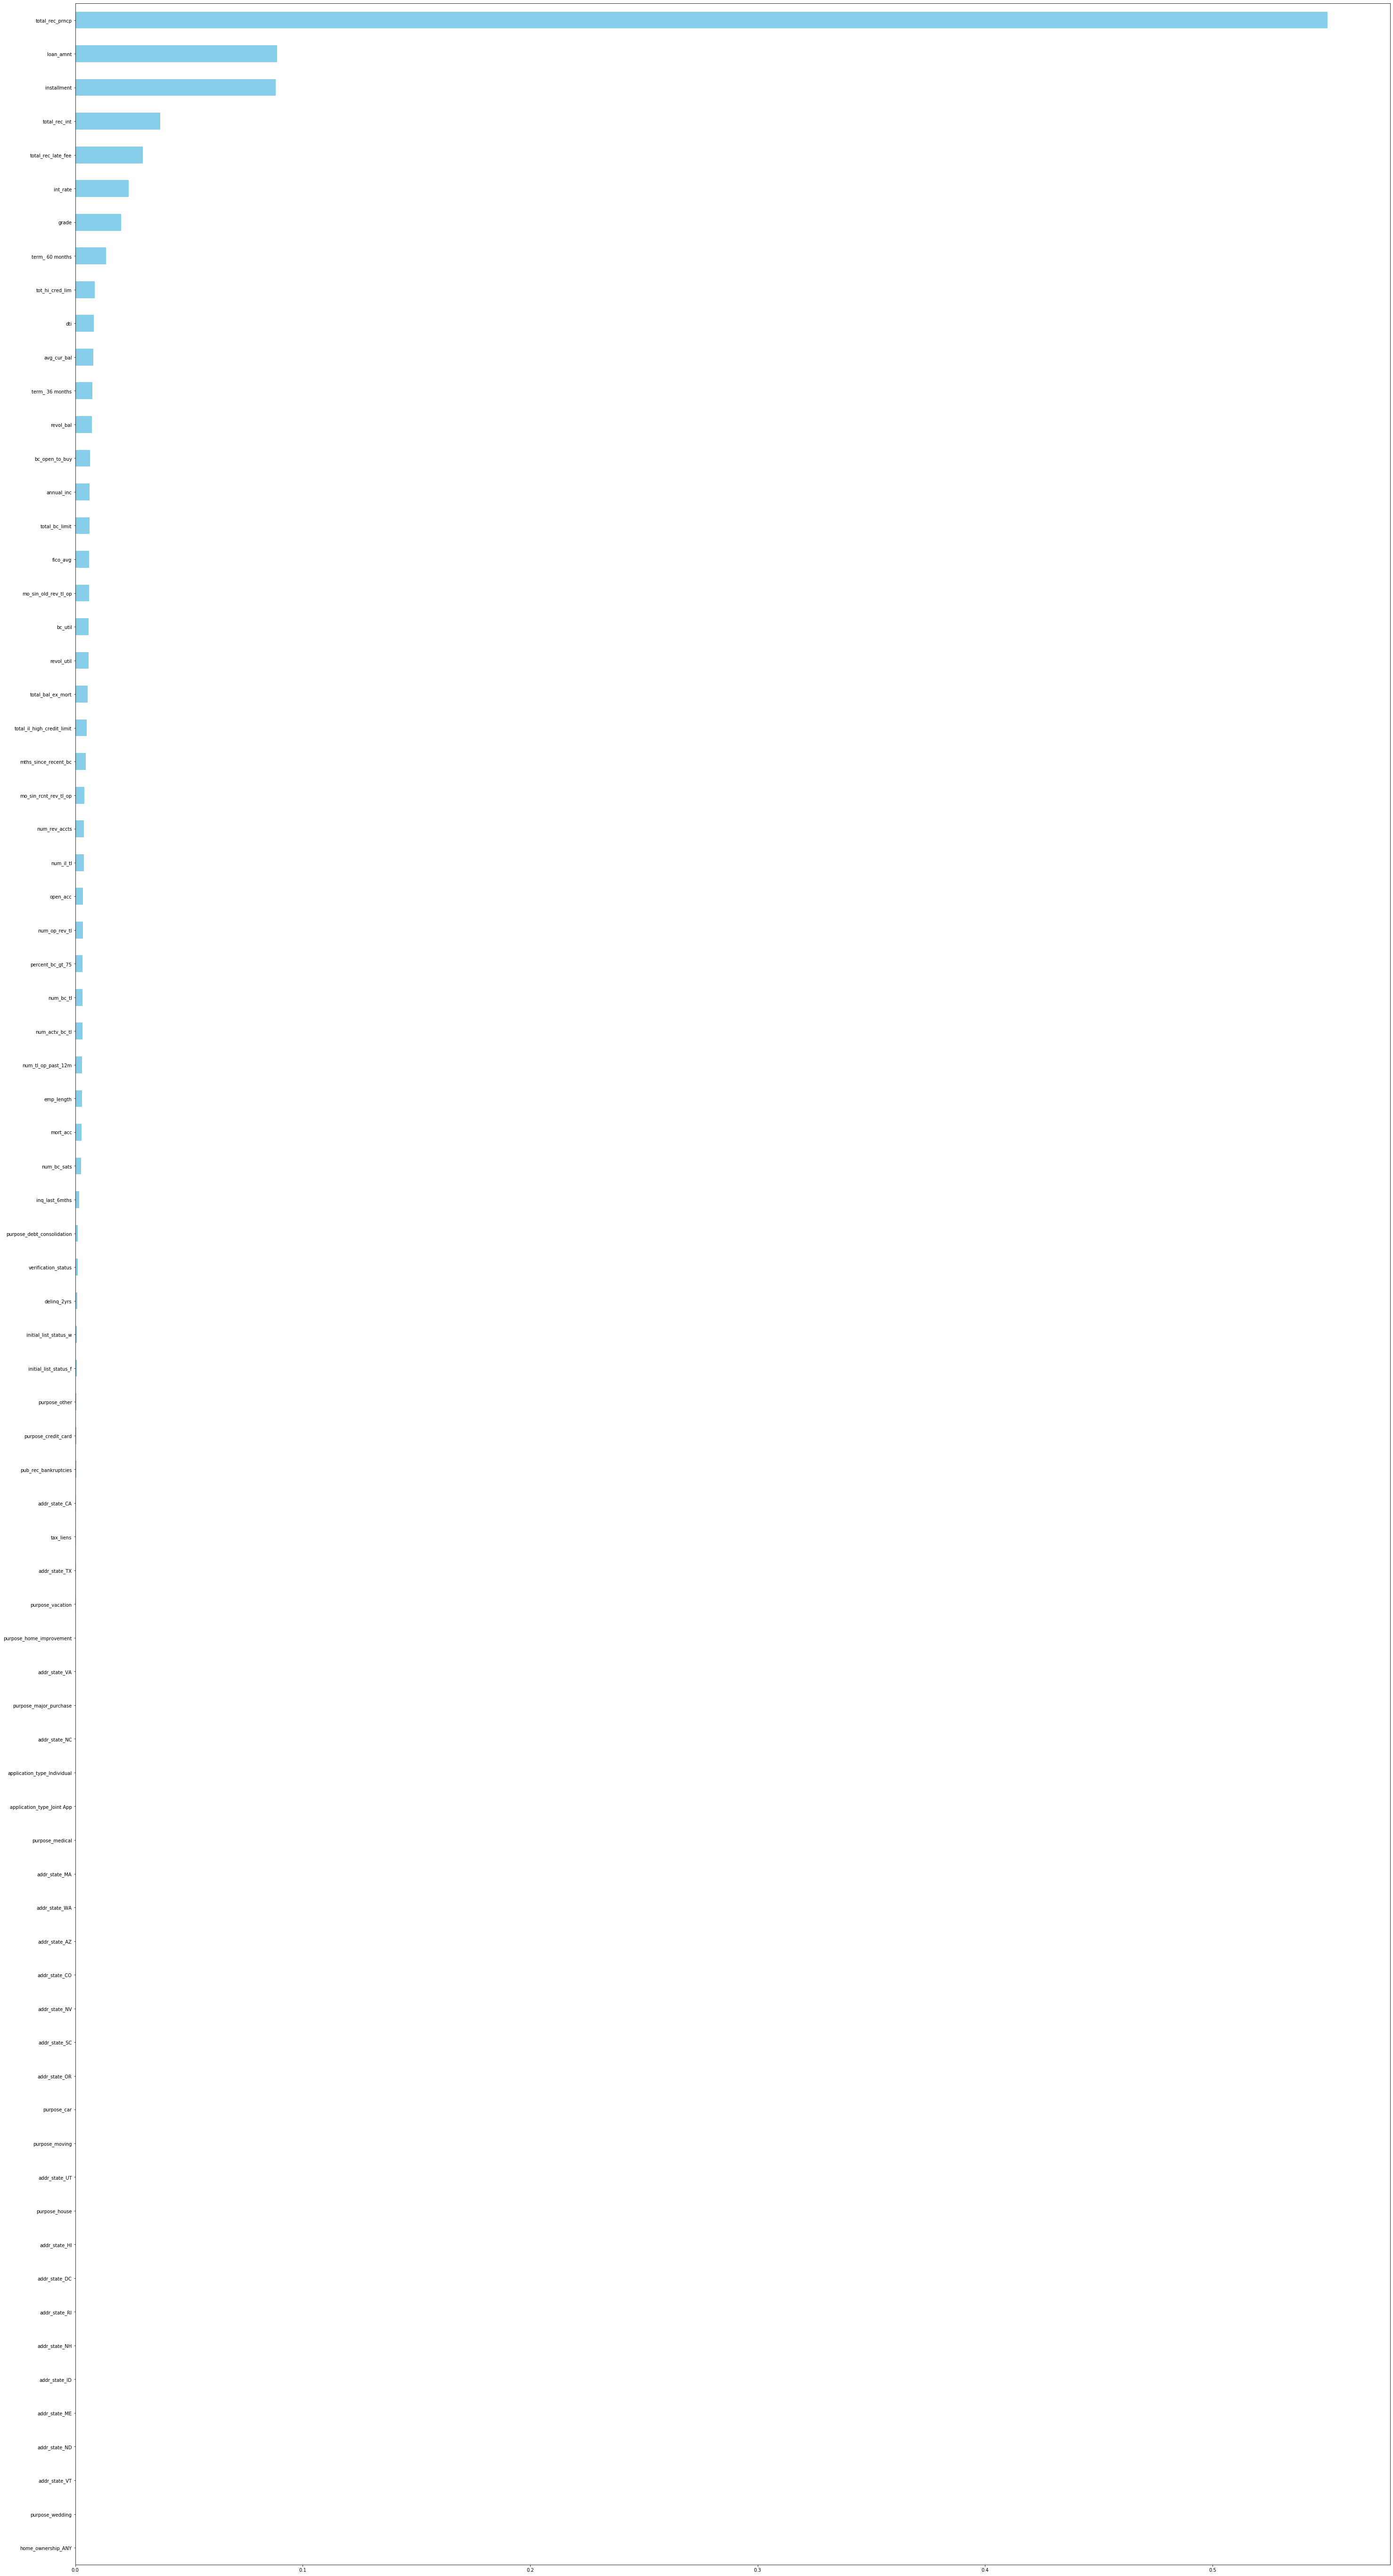

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Create a pd.Series of features importances
importances_rf = pd.Series(rf.feature_importances_, index = X.columns)

# Sort importances_rf
sorted_importances_rf = importances_rf.sort_values()

# Make a horizontal bar plot
plt.figure(figsize=(50,100))
sorted_importances_rf.plot(kind='barh', color='skyblue'); 
plt.show()

## Scaling Data

In [ ]:
df_X =df_X[log_cols]

In [ ]:
from sklearn.preprocessing import StandardScaler

# Using scale_numeric to scale independent numeric variables
def scale_numeric(data, numeric_columns, scaler):
    for col in numeric_columns:
        data[col] = scaler.fit_transform(data[col].values.reshape(-1, 1))
    return data


scaler = StandardScaler()
df_X = scale_numeric(df_X, df_X.columns, scaler)

## General Logistic Regression Model 

              precision    recall  f1-score   support

           0       1.00      0.99      0.99     38732
           1       1.00      1.00      1.00    152936

    accuracy                           1.00    191668
   macro avg       1.00      0.99      1.00    191668
weighted avg       1.00      1.00      1.00    191668



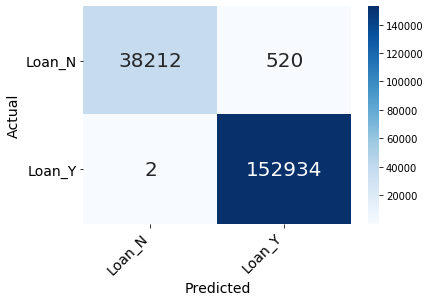

In [ ]:
# Splitting dataset into 70% Test, 30% Train
X_train, X_test, y_train, y_test = train_test_split(df_X, df_y, test_size=0.30, stratify = df_y, random_state=42)

from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline

# Creating Logistic Regression Model with Scaler
log = make_pipeline(StandardScaler(),
                    LogisticRegression(random_state=0, max_iter = 500))
log.fit(X_train, y_train)

from sklearn.svm import SVC

#Predict the response for test dataset
y_pred = log.predict(X_test)

# Visualize the confusion matrix
from sklearn.metrics import confusion_matrix
con_matrix = confusion_matrix(y_test, y_pred)
confusion_matrix_df = pd.DataFrame(con_matrix, ('Loan_N', 'Loan_Y'), ('Loan_N', 'Loan_Y'))
heatmap = sns.heatmap(confusion_matrix_df, annot=True, annot_kws={"size": 20}, fmt="d", cmap="Blues")
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize = 14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize = 14)
plt.ylabel('Actual', fontsize = 14)
plt.xlabel('Predicted', fontsize = 14)
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update bottom and top margins


# Print the classification report
from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred))

## Logistic Regression Model for Grades E, F, G

0.9941655295722956
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      8799
           1       0.99      1.00      1.00     12454

    accuracy                           0.99     21253
   macro avg       1.00      0.99      0.99     21253
weighted avg       0.99      0.99      0.99     21253



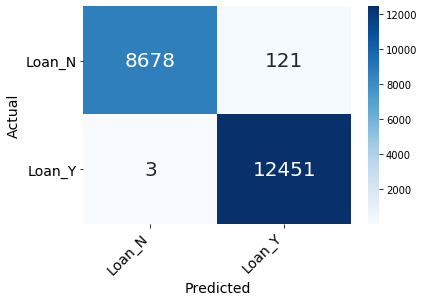

In [ ]:
# Creating subset of loans with grades E, F, G then splitting it into train and test
FG = samp.loc[(samp['grade'] == 7)|(samp['grade'] == 6)|(samp['grade'] == 5) ]
FG_X = FG[log_cols]
FG_y = FG.loan_status
fX_train, fX_test, fy_train, fy_test = train_test_split(FG_X, FG_y, test_size=0.33, stratify = FG_y,)

from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.svm import SVC

# Creating Logistic Regression Model for EFG grade loans only
efg_log = make_pipeline(StandardScaler(),
                    LogisticRegression(random_state=0, max_iter = 100000))
efg_log.fit(fX_train, fy_train)

#Scoring EFG Model
efg_log.score(fX_test, fy_test)

#Predict the response for test dataset
fy_pred = efg_log.predict(fX_test)

# Output the accuracy of our prediction
from sklearn.metrics import accuracy_score
print(accuracy_score(fy_test, fy_pred))
#best_model(logreg)

# Visualize the confusion matrix to make it easier to read
from sklearn.metrics import confusion_matrix
con_matrix = confusion_matrix(fy_test, fy_pred)
confusion_matrix_df = pd.DataFrame(con_matrix, ('Loan_N', 'Loan_Y'), ('Loan_N', 'Loan_Y'))
heatmap = sns.heatmap(confusion_matrix_df, annot=True, annot_kws={"size": 20}, fmt="d", cmap="Blues")
heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize = 14)
heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize = 14)
plt.ylabel('Actual', fontsize = 14)
plt.xlabel('Predicted', fontsize = 14)
b, t = plt.ylim() # discover the values for bottom and top
b += 0.5 # Add 0.5 to the bottom
t -= 0.5 # Subtract 0.5 from the top
plt.ylim(b, t) # update t


# Print the classification report
from sklearn.metrics import classification_report
print(classification_report(fy_test, fy_pred))

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

# Using K-Fold Validation to test 
kf = kf = KFold(n_splits=5)
print(cross_val_score(efg_log, FG_X, FG_y, cv=kf))

[0.99565285 0.99518708 0.9939441  0.99347826 0.99565217 0.99518634
 0.99627329 0.99642857 0.99487578 0.9947205 ]


# Feature Importance for ROI

In [ ]:
# Preparing data to analyze feature importance of high ROI
roi_df = samp.copy()
roi_X = samp[samp['ROI'] >50]
roi_y = roi_X.ROI
roi_X = roi_X.drop(columns=['ROI'])
rX_train, rX_test, ry_train, ry_test = train_test_split(roi_X, roi_y, test_size=0.33, random_state=42)

from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=25, 
                            bootstrap = True, 
                            max_features = 'auto', 
                            min_samples_leaf = 5, 
                            random_state=42)

# Fit 'rf' to the training set
rf.fit(rX_train, ry_train)
# Create a pd.Series of features importances
importances_rf = pd.Series(rf.feature_importances_, index = roi_X.columns)

# Sort importances_rf
sorted_importances_rf = importances_rf.sort_values()

# Make a horizontal bar plot
plt.figure(figsize=(50,100))
sorted_importances_rf.plot(kind='barh', color='skyblue'); 
plt.show()

# Testing Investment Strategies

In [ ]:
def strategy(n, props, amnt_invested):
    global log_cols
    # Calculates the number of loans to invest in for loans of each grade
    totals = [n*x for x in props]
    new_totals = []
    for x,y in zip(totals, amnt_invested):
        if y!=0:
            new_totals.append(int(x//y))
        else:
            new_totals.append(0)
            
    # Taking a random sample of the data that the models have not seen before 
    # and extracting the columns necessary for predicting loan status       
    invest1 = unseen.sample(n=10000,replace=False)
    invest1_X = invest1.drop(columns=['loan_status'])
    invest1_X = invest1_X[log_cols]
    invest1_y = invest1.loan_status
    invest1_ROI = invest1.ROI
    
    invest1_pred = log.predict(invest1_X)
    invest1_df = invest1_X.copy()
    invest1_df['prediction'] = invest1_pred.copy()
    invest1_df['ROI'] = invest1_ROI.copy()

    invest1_EFG = invest1_df[(invest1_df['grade'] == 7) & (invest1_df['grade'] == 6) | (invest1_df['grade'] == 5)].copy()
    efg_roi = invest1_EFG.ROI
    invest1_EFGX = invest1_EFG[log_cols]

    efg_pred = efg_log.predict(invest1_EFGX)
    invest1_EFGX['prediction'] = efg_pred.copy()
    invest1_EFGX['ROI'] = efg_roi.copy()

    invest1_A = invest1_df[(invest1_df['grade'] == 1) & (invest1_df['prediction']==1)]
    invest1_B = invest1_df[(invest1_df['grade'] == 2) & (invest1_df['prediction']==1)]
    invest1_C = invest1_df[(invest1_df['grade'] == 3) & (invest1_df['prediction']==1)]
    invest1_D = invest1_df[(invest1_df['grade'] == 4) & (invest1_df['prediction']==1)]
    invest1_E = invest1_EFGX[(invest1_EFGX['grade'] == 5) & (invest1_EFGX['prediction']==1)]
    invest1_F = invest1_EFGX[(invest1_EFGX['grade'] == 6) & (invest1_EFGX['prediction']==1)]
    invest1_G = invest1_EFGX[(invest1_EFGX['grade'] == 7) & (invest1_EFGX['prediction']==1)]
    
    
    # Filtering Grade A loans using filters to minimize risk
    a = invest1_A.sort_values(by=['emp_length', 'annual_inc'], ascending = False)
    A = a.loc[(a.pub_rec_bankruptcies == 0.0) & (a.tax_liens == 0.0) & (a.verification_status == 1) & 
          (a.delinq_2yrs == 0.0) & (a.emp_length > 5)].sort_values(by='installment').head(new_totals[0])
   
    # Crreating and filliing list of individual amounts invested in each loan
    Aamnt = [amnt_invested[0] for x in range(len(A))]
    
    
    # Filtering Grade B loans using filters to minimize risk
    b = invest1_B.sort_values(by=['emp_length', 'annual_inc'], ascending = False)
    B = b.loc[(b.pub_rec_bankruptcies == 0.0) & (b.tax_liens == 0.0) & (b.verification_status == 1) & 
          (b.delinq_2yrs == 0.0) & (b.emp_length > 5)].sort_values(by='installment').head(new_totals[1])

    # Crreating and filliing list of individual amounts invested in each loan
    Bamnt = [amnt_invested[1] for x in range(len(B))]
   

    # Filtering Grade C loans using filters to minimize risk
    c = invest1_C.sort_values(by=['emp_length', 'annual_inc'], ascending = False)
    C = c.loc[(c.pub_rec_bankruptcies == 0.0) & (c.tax_liens == 0.0) &
              (c.verification_status == 1)& (c.delinq_2yrs == 0.0) & 
              (c.emp_length > 5)].sort_values(by='installment').head(new_totals[2])
    
    # Crreating and filliing list of individual amounts invested in each loan
    Camnt = [amnt_invested[2] for x in range(len(C))]

    
    # Filtering Grade D loans using filters to minimize risk
    d = invest1_D.sort_values(by=['emp_length', 'annual_inc'], ascending = False)
    D = d.loc[(d.pub_rec_bankruptcies == 0.0) & (d.tax_liens == 0.0) & (d.verification_status == 1) & 
          (d.delinq_2yrs == 0.0) & (d.emp_length > 5)].sort_values(by='installment').head(new_totals[3])
    
    # Crreating and filliing list of individual amounts invested in each loan
    Damnt = [amnt_invested[3] for x in range(len(D))]

    
    # Filtering Grade E loans using filters to minimize risk
    e = invest1_E.sort_values(by=['emp_length', 'annual_inc'], ascending = False)
    E = e.loc[(e.pub_rec_bankruptcies == 0.0) & (e.tax_liens == 0.0) & (e.verification_status == 1) & 
          (e.delinq_2yrs == 0.0) & (e.emp_length > 5)].sort_values(by='installment').head(new_totals[4])
    
    # Crreating and filliing list of individual amounts invested in each loan
    Eamnt = [amnt_invested[4] for x in range(len(E))]

   

    # Filtering Grade F loans using filters to minimize risk
    f = invest1_F.sort_values(by=['emp_length', 'annual_inc'], ascending = False)
    F = f.loc[(f.pub_rec_bankruptcies == 0.0) & (f.tax_liens == 0.0) & (f.verification_status == 1) & 
          (f.delinq_2yrs == 0.0) & (f.emp_length > 5)].sort_values(by='installment').head(new_totals[5])
    
    # Crreating and filliing list of individual amounts invested in each loan
    Famnt = [amnt_invested[5]  for x in range(len(F))]

    
    # Filtering Grade G loans using filters to minimize risk
    g = invest1_G.sort_values(by=['emp_length', 'annual_inc'], ascending = False)
    G = g.loc[(g.pub_rec_bankruptcies == 0.0) & (g.tax_liens == 0.0) & (g.verification_status == 1) & 
          (g.delinq_2yrs == 0.0) & (g.emp_length > 5)].sort_values(by='installment').head(new_totals[6])
    
    # Crreating and filliing list of individual amounts invested in each loan 
    Gamnt = [amnt_invested[6] for x in range(len(G))]

    
    # Combining all loans that will be used for investing
    grade_picks = [B, C, D, E, F, G]
    full = A
    for i in range(6):
        full = full.append(grade_picks[i])
    
    # Combining all loans of grades E, F, and G that will be used for investing
    grade_picks = [F, G]    
    EFG_only = E
    for i in range(2):
        EFG_only = full.append(grade_picks[i])
        
    # Combining all individual amounts invested in each loan into a list
    invest_amnt = []
    amnts = [Aamnt, Bamnt,Camnt,Damnt,Eamnt,Famnt,Gamnt]
    for i in range(7):
        invest_amnt.extend(amnts[i])
    
    # Adding investment amounts to datafram of all loans chosen 
    full['invest_amnts'] = invest_amnt
    
    # Calculating the amount invested
    total_invested = full['invest_amnts'].sum()
    
    # Calculating the return
    total_back = (full['ROI']*full['invest_amnts']).sum()
    
    # Calculating average ROI of all loans chosen 
    avg_roi = full['ROI'].mean()

    return(total_invested, total_back, avg_roi, (total_back - total_invested) / total_invested, EFG_only)

All strategies have the same foundation. They are based primarily on the logistic regression model's ability to pick good loans. But there's still more we can do to make the most of investments. Now that we know which loans are safe, we can start looking at individual loans.

In the function above, we are prioritizing employee length and annual income, as these were seen to be important features in the Decision Tree Classifier. We also filter out all loans with bankruptcies, tax liens, income that has not been verified, any delinquencies in the last 2 years and anyone with an employment length less than 5. These filters are in place to decrease risk. 

The variation in strategy comes into play when we consider how to diversify our portfolio. In each strategy we aim to invest in 100 loans. Each strategy varies in distribution of grade and the amount of money invested to each loan of a particular grade. 

## Investment Strategy #1 : Lots of Loans Little Money


In [ ]:
# Simulating Investment Strategy #1.1 where many loans are chosen and invested in small amounts
def strat1(money_to_invest):
    results = [] 
    keep = strategy(money_to_invest, [0.22,.22,.30,.15,.07,.02,.02], [25,25,50,50,25,25,25])
    results.append(keep[3])
    return np.asarray(results)

In [ ]:
strat1_list = []
for i in range(10):
    strat1_list.append(strat1(10000))
print(np.asarray(strat1_list).mean())

11.820267431938134


## Investment Strategy #2.1 : (Few Loans, Lots of Money - A/B Only)

In [ ]:
# Simulating Investment Strategy #2.1, 10 times and taking the mean ROI
def strat2(money_to_invest): 
    results = [] 
    keep = strategy(money_to_invest, [0.50,0.50,0,0,0,0,0], [100,100,0,0,0,0,0])
    results.append(keep[3])
    return results

In [ ]:
# Simulating investment strategy 2.1, 10 times and taking the mean ROI
strat2_list = []
for i in range(10):
    strat2_list.append(strat2(10000))
print(np.asarray(strat2_list).mean())

7.398925005207222


## Investment Strategy #2.2 : (Few Loans, Lots of Money - A/B Concentrated)

In [ ]:
# Investment Strategy where fewer loans chosen but they investments in each loan are relatively higher
def strat22(money_to_invest): 
    results = [] 
    keep = strategy(money_to_invest, [.25,.25,.10,.10,.10,.10,.10], [100,100,100,100,100,100,100])
    results.append(keep[3])
    return results

In [ ]:
# Simulating investment strategy 2.2, 10 times and taking the mean ROI
strat22_list = []
for i in range(10):
    strat22_list.append(strat22(10000))
print(np.asarray(strat22_list).mean())

10.608904878824456


## Investment Strategy #2.3 : (Few Loans, Lots of Money - Platform Mix)

In [ ]:
# Investment Strategy #2.3 Where investments are made with the proportions os
def strat23(money_to_invest): 
    results = [] 
    keep = strategy(money_to_invest, [.1706, 0.2905,0.2878,0.1502,0.0701,0.0238,0.00681], [100,100,100,100,100,100,100])
    results.append(keep[3])
    return results

In [ ]:
# Simulating investment strategy 2.3, 10 times and taking the mean ROI
strat23_list = []
for i in range(10):
    strat23_list.append(strat23(10000))
print(np.asarray(strat22_list).mean())

10.092765562338746


## Investment  Strategy #3 (Only As)

In [ ]:
# Only investing in grade A loans
def strat3(money_to_invest): 
    results = []
    keep = strategy(money_to_invest, [1,0,0,0,0,0,0], [50,0,0,0,0,0,0])
    results.append(keep[3])
    return np.asarray(results).mean()

In [ ]:
# Simulating investment strategy 3, 10 times and taking the mean ROI
strat3_list = []
for i in range(10):
    strat3_list.append(strat3(10000))
print(np.asarray(strat3_list).mean())

6.493587969385186


## Investment Strategy #4 (Extreme A/B/C)

In [ ]:
# Investment Strategy #4 Where investments are only made in loans with grades A, B, and C
def strat4(n): 
    results = []
    keep = strategy(n, [.333,.333,.333,0,0,0,0], [50,50,50,0,0,0,0])
    results.append(keep[3])
    return results

In [ ]:
# Simulating Investment Strategy #4, 10 times and taking the mean ROI
strat4_list = []
for i in range(10):
    strat4_list.append(strat4(10000))
print(np.asarray(strat4_list).mean())

9.232350382490798


## Investment Strategy #5 (Extreme E/F/G)

In [ ]:
# Simulating Strategy #5 where all loans come from grades E, F, and G
def strat5(n): 
    results = []
    keep = strategy(n, [0,0,0,0,.333,.333,.333], [0,0,0,0,50,50,50])
    results.append(keep[3])
    results.append(keep[4])
    return results

In [ ]:
# The loans the tool reccomends investing in
x = strat5(10000)
x[1]

,loan_amnt,int_rate,installment,grade,emp_length,annual_inc,dti,delinq_2yrs,inq_last_6mths,open_acc,revol_bal,revol_util,total_rec_prncp,total_rec_int,total_rec_late_fee,avg_cur_bal,bc_open_to_buy,bc_util,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mort_acc,mths_since_recent_bc,num_actv_bc_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_tl_op_past_12m,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,fico_avg,verification_status,term_ 36 months,term_ 60 months,application_type_Individual,application_type_Joint App,initial_list_status_f,initial_list_status_w,home_ownership_ANY,purpose_car,purpose_credit_card,purpose_debt_consolidation,purpose_home_improvement,purpose_house,purpose_major_purchase,purpose_medical,purpose_moving,purpose_other,purpose_vacation,purpose_wedding,addr_state_AZ,addr_state_CA,addr_state_CO,addr_state_DC,addr_state_HI,addr_state_ID,addr_state_MA,addr_state_ME,addr_state_NC,addr_state_ND,addr_state_NH,addr_state_NV,addr_state_OR,addr_state_RI,addr_state_SC,addr_state_TX,addr_state_UT,addr_state_VA,addr_state_VT,addr_state_WA,prediction,ROI
1224066,1200.0,19.99,44.60,5.0,8.0,25000.0,48.06,0.0,1.0,11.0,10509.0,44.0,1200.00,377.57,0.0,2178.0,7022.0,49.5,376.0,10.0,0.0,10.0,4.0,5.0,9.0,4.0,9.0,16.0,2.0,50.0,0.0,0.0,41620.0,21782.0,13900.0,17720.0,712.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,30.149525
1291051,2000.0,22.45,76.85,5.0,10.0,32000.0,39.78,0.0,0.0,7.0,12794.0,88.2,1002.99,608.37,0.0,6330.0,194.0,98.4,151.0,10.0,0.0,10.0,3.0,3.0,6.0,3.0,4.0,12.0,3.0,100.0,0.0,0.0,57666.0,44307.0,12500.0,43166.0,672.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,-24.714010
1303226,2325.0,22.45,89.34,5.0,10.0,29000.0,27.57,0.0,0.0,11.0,27044.0,75.8,2325.00,222.77,0.0,2459.0,1423.0,95.0,166.0,4.0,0.0,17.0,7.0,7.0,9.0,3.0,11.0,16.0,1.0,85.7,0.0,0.0,35700.0,27044.0,28400.0,0.0,682.0,1.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,8.485690
1245183,3000.0,18.49,109.20,5.0,10.0,21600.0,27.90,0.0,1.0,9.0,492.0,3.0,3000.00,688.04,0.0,771.0,13108.0,3.6,100.0,6.0,0.0,6.0,5.0,6.0,7.0,5.0,7.0,8.0,7.0,0.0,0.0,0.0,24867.0,6937.0,13600.0,8467.0,747.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,21.705320
1254025,3250.0,19.52,119.99,5.0,6.0,13000.0,7.29,0.0,1.0,4.0,2943.0,57.7,3250.00,1066.99,0.0,736.0,730.0,73.9,202.0,1.0,0.0,1.0,2.0,3.0,4.0,1.0,4.0,5.0,3.0,66.7,0.0,0.0,5100.0,2943.0,2800.0,0.0,667.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,31.502157
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1294451,16825.0,21.67,461.54,5.0,10.0,56680.0,25.47,0.0,1.0,31.0,27878.0,58.0,16825.00,8072.50,0.0,929.0,1291.0,75.0,240.0,2.0,3.0,2.0,17.0,19.0,19.0,2.0,29.0,35.0,5.0,52.9,0.0,0.0,48151.0,28614.0,21950.0,0.0,692.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1,46.499406
1258672,18000.0,19.19,468.82,5.0,10.0,96000.0,9.81,0.0,0.0,5.0,7025.0,31.5,18000.00,2826.07,0.0,7933.0,5676.0,26.3,103.0,16.0,3.0,16.0,2.0,2.0,2.0,15.0,4.0,4.0,3.0,0.0,0.0,0.0,55436.0,39667.0,7700.0,33136.0,667.0,1.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0